In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import preprocessor as p

import string
from string import punctuation

import collections
from collections import Counter

import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score


import en_core_web_sm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brajeshkarna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Tweets

In [2]:
def LoadTweetFile():
    data = pd.read_csv("/Users/brajeshkarna/Documents/FatTalk/combined_tweets_2021.csv")
    return data

tweetDf = LoadTweetFile()

/var/folders/d9/ghy46zzj2454k38j3h7282mr0000gn/T/ipykernel_8878/104894681.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  tweetDf = LoadTweetFile()


### Select tweets for date range and clean tweets, remove hashtags too from the tweets

In [3]:
tweets_bowl = pd.DataFrame(tweetDf[['user_id', 'tweet','tweet_created_at','user_username','searchquery']])
#removing if there is string on date columns and making index and sorting by the date
tweets_bowl['tweet_created_at'] = pd.to_datetime(tweets_bowl['tweet_created_at'], errors='coerce')
tweets_bowl = tweets_bowl.dropna(subset=['tweet_created_at'])
tweets_bowl = tweets_bowl.set_index(tweets_bowl['tweet_created_at'])
tweets_bowl = tweets_bowl.sort_index()
##Split data based on date
#tweets_bowl = tweets_bowl['2021-11-23': '2021-11-26']

In [4]:
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df['tweets'] = df[text_field].apply(lambda x: re.sub(r'(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?','', x)) 
    return df

tweets_bowl = clean_text(tweets_bowl, 'tweet')

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

def clean_tweets(df):
  tempArr = []
  for line in df:
    p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER,p.OPT.RESERVED)
    tmpL = p.clean(line)
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) 
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr


tweets_bowl['tweets'] = clean_tweets(tweets_bowl['tweet'])
tweets_bowl['tweets'] = tweets_bowl['tweets'].apply(lambda x: x.replace('#', ''))

### Furnish tweets

In [5]:
nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
       if i.lower() not in stop:
           word = lemmatizer.lemmatize(i)
           final_text.append(word.lower())
    return " ".join(final_text)


tweets_bowl.tweets = tweets_bowl.tweets.apply(furnished)

### Dictionary words for domains

In [6]:
fat_related_words = '''Heavy Excess weight Excess fat Overweight Big Weight problem Obese Obesity
Obeast Large Large size Hefty High BMI Fat Fatness heffer Huge Thick Thicc/thiccc Thict thic fit
Thiccums Thickie THICCCCC Thickness Plump plumper Round Unfit Fluffy unhealthy Unhealthy BMI Unhealthy weight
BMI Unhealthy body weight Heaviness Back fat Gaining weight Normal weight Chubby Chubble Chubbin’
Chubblies chubby breasts Chubba Chubby rubby Gordo Morbid obesity Plus size Curvy Full figured
Weight problem Big boned Well endowed Big girl Fat slob Voluptuous Husky Huskaroo Chunky Piernuda leggy referring to thigh size
Nalgona big butt Fat ass FUPA fat upper pubic area FUPA fat upper pussy area Phanny pack same as FUPA Fat fuck
Fat fucking'''

In [7]:
economy_related_words = '''agriculture infrastructure capitalism trading service sector technology  economical supply 
industrialism efficiency frugality retrenchment downsizing   credit debit value 
economize   save  economically
economies sluggish rise   rising spending conserve trend 
low-management  decline   industry impact poor  
profession    surplus   fall
declining  accelerating interest sectors balance stability productivity increase rates
pushing expanding stabilize  rate industrial borrowing struggling
deficit predicted    increasing  data
economizer analysts investment market-based economy   debt free enterprise
medium  exchange metric savepoint scarcity capital bank company stockholder fund business  
asset treasury tourism incomes contraction employment jobs upturn deflation  macroeconomics
bankruptcies exporters hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation 
quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture capital
mutual fund plan economy mortgage lender unemployment rate credit crunch central bank financial institution
bank rate custom duties mass-production black-market developing-countries developing economic-growth gdp trade barter 
distribution downturn economist'''

In [8]:
social_related_words = '''sociable, gregarious societal friendly society socialization political  sociality 
interpersonal  ethnic socially party welfare public community socialist societies development
network humans socialism collective personal corporation social constructivism
relations volition citizenship brute   attitude rights socio 
socioeconomic ethics civic communal marital  sociale socialized communities     
policy   unions        
institutions values     governmental   organizations jamboree 
festivity    fairness  support  care  
sides   activism     unsocial psychosocial 
socializing psychological distributional  demographic  participation reunion 
partygoer partyism festive power network gala housewarming celebration counterparty   social-war
particularist interactional ideational asocial'''

In [9]:
culture_related_words  = ''' ethnicity heritage modernity spirituality marxismmaterial culture 
ethos nationality humanism romanticism civilisation traditionalism genetics
kinship heredity marriage   indigenous  archeology  acculturate  
ontogenesis viniculture modern clothes     rooted 
cicero societies history roots influence geography historical folk origins 
phenomenon teleology ancient aspects perspective liberalism nowadays community style unique prevalent describes 
today  origin   modernity beliefs  genre barbarian ethnic 
colonization cultural universal organization western-civilization structuralism  culture 
heathen pagan transculturation culture peasant classicist nativism anarchy ungrown philosophic cult  
consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism  
mongolian cosmopolitan epistemology lifestyles diversity chauvinism westernization materialism vernacular 
homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse
puritanism modernism intellectualism  exclusiveness elitism  colonialism  
pentecostalism paganism nationwide expansion rural  auxesis kimono 
culturize alethophobia nettlebed japanification  dongyi clannishness insularity hybridity
westernisation foreignness worldview exclusionism enculturation ethnocentrism  confucianist vulgarization
shintoism  westernism denominationalism    deracination
eurocentrism  cosmologies  emotiveness bohemianism territorialism
philosophical-doctrine ethnic minority social-darwinism  theory cultural evolution belief systemfolk music 
traditional art house karl-marx   theorymedia  
film-theory art history museum studies cultural artifact'''

In [10]:
health_related_words = '''disease obesity world health organization medicine nutrition well-being exercise welfare wellness health care public health 
nursing stress safety hygiene research social healthy condition aids epidemiology healthiness wellbeing
care illness medical dieteducation infectious disease environmental healthcare physical fitness hospitals 
health care provider doctors healthy community design insurance sanitation human body patient mental health
medicare agriculture health science fitnesshealth policy  weight loss physical therapy psychology pharmacy
metabolic organism human lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family
eudaimonia eudaemonia air house prevention genetics public families poor needs treatment communicable disease 
study protection malaria development food priority management healthful mental provide department administration
programs help assistance funding environment improving emergency need program affected schools private mental illness 
treat diseases preparedness perinatal fertility sickness veterinary sanitary pharmacists behavioral midwives
gerontology infertility hospitalization midwifery cholesterol childcare pediatrician pediatrics medicaid asthma 
pensions sicknesses push-up physical education body-mass-index eat well gymnastic apparatus tune up good morning 
bathing low blood-pressure heart attack health club ride-bike you feel good eczema urticaria dermatitis sunburn overwork 
manufacturing medical sociology need exercise run'''

In [20]:
new_fat_vocab = '''fat like feel look belly people actually body weight get he big good as cause amp know telling make think say really want god lose much son mama would bc see health even time war eat day way right still also someone got diet love need man skinny weightloss something person thor food every loss healthy tell back fatphobia bad fucking wanna overweight going today getting here better never life af strength fitness well obese old shit help eating showing upset winner take work stop dm around lot aid woman made happy strongman bodybuilder always martin competition ignorance dehydrated weakest licis new fuck since there hate white lol doesnt gonna ill exercise beautiful ever ugly talk best thing free guy fatloss thin joe playing first many nice keep important muscle last little try fit thigh picture yall looking call size without burn saying everyone making face bmi long real workout trying literally week called gain gym come sick tweet sure feeling far nutrition treating year wrong everything chubby warrior le girl black pretty tired thought hard losing edtwt nordic miss mean pic lost theology suppremacist fertiliy bitch low waist reduce anything nothing go yeah full men high sorry kid care lb single night great find obesity kind working give away married used skin truth gorgeous start thinking may ur extremely whole enough special father anyone grand rising live fast protein sends nigeria lucky post damn point maybe already funny loseweight energy order stomach might next dress month reason shaming perfect cat remember covid show coffee friend meal weightlossjourney another probably saw cute heart rid narrative hot shes child sugar watch home increase type flat idk else calorie read seeing part justin baby fact taking respectful actively mistreats different tea family natural head world calling believe talking hurt bit either started lmao self finally cream rn morning tho super fan exist boy extra ago least parent spilled ate bear wish become small beauty change huge house plus sometimes seen arm found living instead burning took sad video hope clothes leg mom therefore top walk ask lifestyle follow binging arent unhealthy shape thanksgiving side keto ja short support money metabolism easy bullied tried shouldnt disgusting guess wear stubborn check result stupid game wanted wasnt pound normal thick school die often understand rest especially hell within gross needed blood almost fun true drinking stuff cope character looked cut end watching trans strong rule anymore lady enjoy mind verzuz coming medical stay others kinda wellness plan problem tonight water left fine wait average omg lower bro weird dr whatsapp amazing mad born mirror sleep nose dude respect half doctor absolutely human rather negative hungry social question mythology learn hair name gotta carbs able cuz motivation hit drink havent idea trainer ready tomorrow healthylifestyle allowed progressive brown insecure duty fatty couldnt government experience actual daily who amount honestly thread store pant overfeed buy gained matter worst risk round training learned due kg worry twitter shame wouldnt fatspo slimming medium horrible marvel lean tummy eye excess hour rich per thanks fasting tf lazy whatever line slim weightlosstransformation online gay unlike definitely tit pay kim goal bigger tu win cool control faster scared quickly v hear dysmorphia felt fatphobic realizing quick wearing lt treat glad second cock herb proud word asked butt play longer available positivity ed easily completely fear design art reminder bellyfat sex explain pack weightlosstips asking disabled place scam quite dick hand course leave penis liberal case imagine depicted issue gone sit worse giving run sir chiseled agree perpetual putting drawing youve non book system pls lie accent outside diabetes dawn tip refuse age based pm blond came large soon delivery traduire chance peux stp bonespo success together brain fatness cry straight poor constantly drop bought appointment draw hugging walking meat enlargement eddiethedermatologist overeat lil personal turn tall supposed dad crazy mentally enlarge intake focus unlearn pain sliming bring soft story racist wonder ugh cardio bed avoid fatburner pussy sitting joke sexy nigga anyway bcs entire positive healthcare young photo build wtf later exactly add break ab folk whenever pregnant job share open program visit prey past yesterday improve disease period nobody youll stress physical claim effective account deal supplement struggle simple ingredient summer starting sense safe simply shirt mass behind dumb healthier kill choose season listening class herbalife scream tiny business btw kimcoffeeroastersuganda juicy animal feed move basically advice red running seriously benefit biggest genuinely fatburning ice fatter news th official attractive wrist reading starving kept choice cannot irl reach heavy mental excuse seems fight fatburn minute society bag designed crush suck front salary forever anti cholesterol unless wow comment alone set helped deep stiff missing tbh close power gave la powerful flab late hearing intact include survive piece milk listen struggling contact discriminate bloated teenager team however till mouth dog level loose notice rubinadilaik naturally tone vaccine inner abt mine public em worth dinner higher otis science death style room gut muscular pig review usually fitnessmotivation chip loving cold following deserve chronically standard height wife scale number source except join possible band vitamin favorite difference egg solution liver dead answer million mostly neck content asexual breakfast reducing indigenous potato gaining finger booty angry truly heard binge main friendly healthyliving chicken excited older forget loses java oil hip fabric voice weightlossmotivation mother personally dark wolf tw effect net image boob stand theyve knew lowcarb seem realize awesome holding serious carb raise fake thankful alot act burner happen king uncomfortable justify easier healthyeating everyday moment music monthly wanting roll perk de holy jean clear funded werent state green effort conclusion chris phobic price experiment list attack known starve butter article vaccinated broke discovery community cheek loved send complete original inside surgery husband titty tight dying recently honest relationship kl gorge zero liberation shut root product improves leo kwa friday according middle nah apparently early comfortable allowance cheese shop cals kick na changed transformation preferential weak rmk built country helping embarrassing menteris certain cow abundant light double cw shed weightgain insulin male woke group accept massive decided vegan unwanted throw trust fuvk ball pasta confident bastard meant mfuko channeling information air couple journey grade grown pregnancy fundis shamed nikatoa nimerudi company chest impossible treated regular youd likely imply implying weigh target sweet mention worked bodybuilding clearly delicious military movie tool bet harder study knowing song bank achieve term ugw co shaking forward car fall phone pick usa figure tend nutritious theyll thinspo beer underweight tiktok progress american hold haha dieting coaching nap phobia fr smile dating lying grow research building afraid button pull hospital lord annoying annoyed challenge spend kidding winter protect evening swear fix expect dream political form grope alive healthyfood taste gotten suffering trash pure lately luck yoga wedding wide aware diabetic noticed waiting sat champion pizza orange retweet sized mentalhealth weekend younger slow bone plenty currently lunch carbohydrate fucked upper anxiety thinner general expert melt grateful near rlly pas culture discourse caught fuckin abdominal provide brother obviously speak female sister stuck deny smaller perfectly ig se bunny poop cancer guide pill wake introducing stored totally smoke fire development bothered inherently happened although ass boost percentage whale antioxidant somehow suit fault barely statistical moderation party appreciated force awful area active beat detox register future extreme met fatigue ashamed somebody glucose standing anybody depressed bout turned remove happens reduced mf tear useless offer surprised fashion hyper ex foot treatment pre despite diagnosed st hide pointed none growing arse accurate date smoking restricting nft realized asf discovered code space taken fitoont bacon toxic bruh cell spent common tv considered distribution energizes johnson save ik personality meet stick cake sound appetite testosterone bug affordable interesting banana lack attention fox duck sunday create contains club given bettertogether sell bottom cooking grab fighting terrible burnfat loser version scientist christmas eugenics uncontrollably shocking warm reality busy trump bunch ultimate lead lovely reaching depression cook b individual sun jealous otherwise process anorexic coz clean daniel bread outfit stretch incl whether tonic eliminate pinned holiday step olestra desert insult paid relate laugh opinion queer km daddy gabby mood smart insect consider dear spike fruit curve died ima huh yea sign door fully catch birthday wall blog robinson fattofit grasshopper carry assed celebration compared nsenene inspired machine confidence weve wyoming changing brought drunk note touch ridiculous smh reduction blunt peace park rate finding petitos everybody hormone eats blackfriday origin biden bullying watched straining harming inflammation buckeye bombarded yr regardless unfold related habit geologist saturated primate onto played opposite blame anywhere giveaway forgot view max sort salt discover worried twice internet recommend miserable showed street chungus moving wrote vilified rd daughter site prefer interested covered secret throughout sport pandemic larger expertise lift crime total advised rib fuel snail lacking bf similar model properly drive stronger british romanticize minor blue offended immune sheet example burger shitty fair construct immediately including becomes towards giant tutorial ignore committed posted appreciate america shot fish coach cover everytime norse rubina overall constant continue okinawa episode keeping stopped market nd match pro buying warmer rank proportion chocolate turkey argument nut insane tryna pressure thicc anyways ruminating itll greek reduces bloating ancient uk systemic visceral majority subculture impact hang resistance dropping vendor scientific confirm icu info pentagon dangerous assuring push dirty caused access enlisted artist eaten write required tree sexualization ashanti dehumanization false glorification capitalism backbone pork intermittent quality shower follower lmfao nasty stressed ketodiet lay assume key response exposed mess desire allow everywhere along govt wild beyond choosing india weightlossdiet starved dietplan harmful includes imma thru physically posting exercising guilty stuffed pot complex forced bald lifting liked condition slightly rolling breaking steroid learning french confused recipe circle bullshit manifesting nearly difficult ideal ad cup fitfam sweating disorder across freaking dropped update allowing bully contest considering blush dey hiding acc decide greasy rice routine app laughing blow lockdown destroying losingweight youtube lion lip instagram obvious delete track idc waste shoulder helo beneficial vote ko decrease handsome collar mum compliment promote random incredibly angel violence biceps processed gender inspiration charge harm recovery highly touching metabolic skinnier cunt feeding min added alcohol japanese rude fresh entitled prevent becoming mindset fed illness purge history monday queen counting jesus existing massage legit salad deficit judge role rock da lonely rip palm favourite wrestle drug september evil lighter vax medicine maam dance yogurt decent lemon adding butchguts breathing weapon hating wet obeast hefty heffer thict thiccums thickie thiccccc thickness plump plumper unfit fluffy heaviness chubble chubbin‚äô chubblies chubba rubby gordo morbid curvy figured boned endowed slob voluptuous husky huskaroo chunky piernuda nalgona fupa phanny pubic breast thiccc'''

In [12]:
fat = furnished(fat_related_words.lower())
economy = furnished(economy_related_words)
social = furnished(social_related_words)
cultural = furnished(culture_related_words)
health = furnished(health_related_words)
new_fat_words = furnished(new_fat_vocab)

In [13]:
string1 = fat
words = string1.split()
fat = " ".join(sorted(set(words), key=words.index))
fat

string2 = economy
words = string2.split()
economy = " ".join(sorted(set(words), key=words.index))
economy

string3 = social
words = string3.split()
social = " ".join(sorted(set(words), key=words.index))
social

string4 = cultural
words = string4.split()
cultural = " ".join(sorted(set(words), key=words.index))
cultural

string5 = health
words = string5.split()
health = " ".join(sorted(set(words), key=words.index))
health

string6 = new_fat_words
words = string6.split()
new_fat_words = " ".join(sorted(set(words), key=words.index))
new_fat_words

'fat like feel look belly people actually body weight get he big good as cause amp know telling make think say really want god lose much son mama would bc see health even time war eat day way right still also someone got diet love need man skinny weightloss something person thor food every loss healthy tell back fatphobia bad fucking wanna overweight going today getting here better never life af strength fitness well obese old shit help eating showing upset winner take work stop dm around lot aid woman made happy strongman bodybuilder always martin competition ignorance dehydrated weakest licis new fuck since there hate white lol doesnt gonna ill exercise beautiful ever ugly talk best thing free guy fatloss thin joe playing first many nice keep important muscle last little try fit thigh picture yall looking call size without burn saying everyone making face bmi long real workout trying literally week called gain gym come sick tweet sure feeling far nutrition treating year wrong everyth

### Jaccard Similarity Scores

In [14]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

def get_scores(group,tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores

f_scores = get_scores(fat, tweets_bowl.tweets.to_list())
e_scores = get_scores(economy, tweets_bowl.tweets.to_list())
s_scores = get_scores(social, tweets_bowl.tweets.to_list())
c_scores = get_scores(cultural, tweets_bowl.tweets.to_list())
h_scores = get_scores(health, tweets_bowl.tweets.to_list())
n_f_scores = get_scores(new_fat_words, tweets_bowl.tweets.to_list())


# create a jaccard scored df.
data  = {'names':tweets_bowl.user_username.to_list(),'fat_score': f_scores,'economic_score':e_scores,'social_score':s_scores,'cultural_score':c_scores,'new_fat_score':n_f_scores}

scores_df = pd.DataFrame(data)

In [15]:
def get_classes(l1, l2,l3,l4,l5):
    fat1 = []
    economy1 = []
    social1 = []
    cultural1 = []
    new_fat_score1 =[]
    
    for i, j,k,l,n in zip(l1, l2,l3,l4,l5):
        m = max(i, j)
        if m == i:
            fat1.append(1)
        else:
            fat1.append(0) 
        if m == j:
            economy1.append(1)
        else:
            economy1.append(0)
        if m == k:
            social1.append(1)
        else:
            social1.append(0)   
        if m == l:
            cultural1.append(1)
        else:
            cultural1.append(0)   
        if m == n:
            new_fat_score1.append(1)
        else:
            new_fat_score1.append(0) 
            
    return fat1,economy1,social1,cultural1,new_fat_score1

l1 = scores_df.fat_score.to_list()
l2 = scores_df.economic_score.to_list()
l3 = scores_df.social_score.to_list()
l4 = scores_df.cultural_score.to_list()
l5 = scores_df.new_fat_score.to_list()


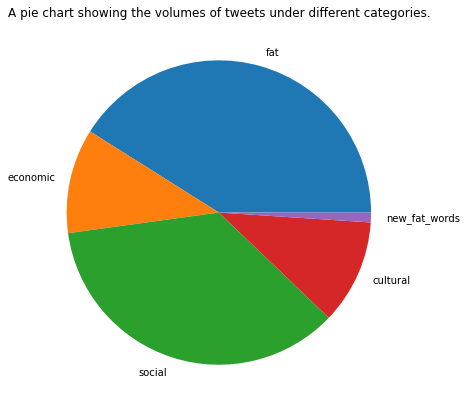

In [16]:
fat1, economy1, social1, cultural1, new_fat_score1 = get_classes(l1, l2,l3,l4,l5)
data = {'name': scores_df.names.to_list(), 'fat':fat1, 'economic':economy1,'social':social1,'cultural':cultural1, 'new_fat_words':new_fat_score1}
class_df = pd.DataFrame(data)
#grouping the tweets by username
new_groups_df = class_df.groupby(['name']).sum()
#add a new totals column
new_groups_df['total'] = new_groups_df['fat'] + new_groups_df['economic'] + new_groups_df['social']+ new_groups_df['cultural'] + new_groups_df['new_fat_words'] 
#add a new totals row
new_groups_df.loc["Total"] = new_groups_df.sum()  

fig = plt.figure(figsize =(10, 7)) 
a = new_groups_df.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show()


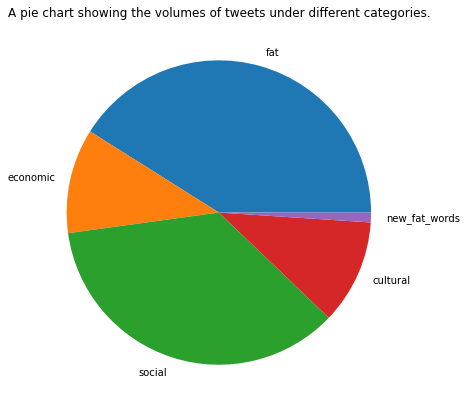

In [17]:
fat2, economy2, social2, cultural2, new_fat_score2 = get_classes(l1, l2,l3,l4,l5)
data = {'name': scores_df.names.to_list(), 'fat':fat1, 'economic':economy1,'social':social1,'cultural':cultural1, 'new_fat_words':new_fat_score1}
class_df = pd.DataFrame(data)
#grouping the tweets by username
new_groups_df = class_df.groupby(['name']).sum()
#add a new totals column
new_groups_df['total'] = new_groups_df['fat'] + new_groups_df['economic'] + new_groups_df['social']+ new_groups_df['cultural'] + new_groups_df['new_fat_words'] 
#add a new totals row
new_groups_df.loc["Total"] = new_groups_df.sum()  

fig = plt.figure(figsize =(10, 7)) 
a = new_groups_df.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show()

In [18]:
fat1, economy1, social1, cultural1, health1 = get_classes(l1, l2,l3,l4,l5)
data = {'name': scores_df.names.to_list(), 'fat':fat1, 'economic':economy1,'social':social1,'cultural':cultural1, 'health':health1}
class_df = pd.DataFrame(data)
#grouping the tweets by username
new_groups_df = class_df.groupby(['name']).sum()

In [19]:
new_groups_df.head()


,fat,economic,social,cultural,health
name,,,,,
0000000003j,1,0,1,0,0
000000_flag,1,0,1,0,0
00000cals,2,0,2,0,0
00000codename,1,0,1,0,0
0000elicca0000,2,0,2,0,0
